Dijkstra's algorithm execution time: 7.649999997738632e-05 seconds


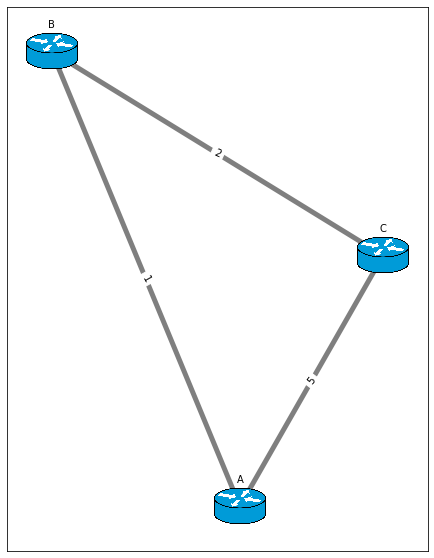

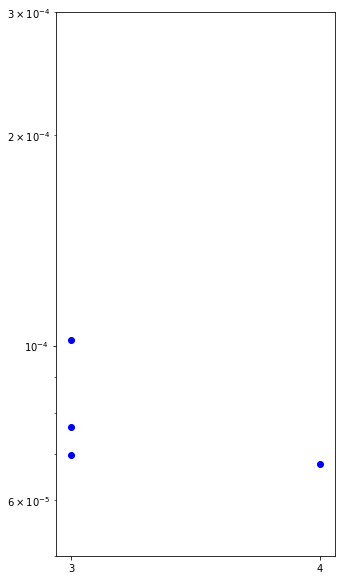

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import heapq
import time
import PIL
import csv
import os
from datetime import datetime
from openpyxl import Workbook
from openpyxl import load_workbook
from collections import defaultdict
from openpyxl.styles import Alignment
from openpyxl.utils import get_column_letter

class Node:
    def __init__(self, name):
        self.name = name
        self.neighbors = {}
        self.distance_table = {}
        self.visited = False
    
    def __lt__(self, other):
        # Define what makes one node "less than" another
        # This could be based on any property of the node
        return self.name < other.name

    def add_neighbor(self, neighbor, cost):
        self.neighbors[neighbor] = cost

    def update_distance_table(self):
        self.distance_table[self] = 0
        for neighbor, neighbor_cost in self.neighbors.items():
            for destination, dest_cost in neighbor.distance_table.items():
                new_cost = neighbor_cost + dest_cost
                if destination not in self.distance_table or new_cost < self.distance_table[destination]:
                    self.distance_table[destination] = new_cost                  

def dijkstra(nodes, start_node):
    # Initialize distance_table for all nodes
    for node in nodes:
        node.distance_table = defaultdict(lambda: float('inf'))

    # Set the distance of the start node to 0
    start_node.distance_table[start_node] = 0

    # Initialize the visited set
    visited = set()

    # Create a priority queue to store nodes with their distances
    queue = [(0, start_node)]

    while queue:
        # Get the node with the minimum distance
        current_distance, current_node = heapq.heappop(queue)

        # Skip this node if it has already been visited
        if current_node in visited:
            continue

        # Mark the current node as visited
        visited.add(current_node)

        # Update the distance_table for the neighbors of the current node
        for neighbor, cost in current_node.neighbors.items():
            # Skip neighbors that have already been visited
            if neighbor in visited:
                continue

            distance = current_distance + cost
            if distance < neighbor.distance_table[start_node]:
                neighbor.distance_table[start_node] = distance
                heapq.heappush(queue, (distance, neighbor))

    # Reset the visited attribute of all nodes
    for node in nodes:
        node.visited = False
        
# Read the Excel file
df = pd.read_excel('Network Graph Information.xlsx')

# Get the number of nodes
num_nodes = len(set(df['Start Node'].tolist() + df['End Node'].tolist()))

# Get the names of the nodes
node_names = set(df['Start Node'].tolist() + df['End Node'].tolist())

# Initialize nodes
nodes = [Node(node_name) for node_name in node_names]

# Initialize edges
try:
    for start_node_name, end_node_name, cost in zip(df['Start Node'], df['End Node'], df['Cost']):
        start_node = next(node for node in nodes if node.name == start_node_name)
        end_node = next(node for node in nodes if node.name == end_node_name)
        start_node.add_neighbor(end_node, cost)
        end_node.add_neighbor(start_node, cost)
except KeyError:
    print('One or more columns do not exist in the DataFrame.')

# Call Dijkstra's algorithm
start_node = nodes[0]  # replace this with your actual start node

# Measure the runtime of the algorithm
start_time = time.perf_counter()
dijkstra(nodes, start_node)
end_time = time.perf_counter()

# Calculate the Dijkstra's algorithm execution time
dijkstra_execution_time = end_time - start_time

# Print the execution time
print(f"Dijkstra's algorithm execution time: {dijkstra_execution_time} seconds")

# Check if the file already exists
file_path = 'Execution Times - Number of Nodes.xlsx'
if os.path.isfile(file_path):
    # Read the existing data from the file
    existing_data = pd.read_excel(file_path)

    # Append the new data to the existing data
    new_data = pd.DataFrame({
        'Number of Nodes': [num_nodes],
        'Dijkstra Execution Time (seconds)': [dijkstra_execution_time]
    })
    execution_times_df = existing_data.append(new_data, ignore_index=True)
else:
    # Create a new DataFrame with the data
    execution_times_df = pd.DataFrame({
        'Number of Nodes': [num_nodes],
        'Dijkstra Execution Time (seconds)': [dijkstra_execution_time]
    })

# Save the updated data to the Excel file
execution_times_df.to_excel(file_path, index=False)

# Load the workbook
wb = load_workbook(filename=file_path)

# Get the active worksheet
ws = wb.active

# Set column width
for col in ws.columns:
    max_length = 0
    column = col[0].column_letter
    for cell in col:
        try:
            if len(str(cell.value)) > max_length:
                max_length = len(cell.value)
        except:
            pass
    adjusted_width = (max_length + 2)
    ws.column_dimensions[column].width = adjusted_width
    
# Center content
for row in ws.iter_rows():
    for cell in row:
        cell.alignment = Alignment(horizontal='center', vertical='center')

# Save the workbook
wb.save(filename=file_path)

# Visualizing the graph (nodes and edges)
G = nx.Graph()
for node in nodes:
    G.add_node(node.name)
try:
    for start_node_name, end_node_name, cost in zip(df['Start Node'], df['End Node'], df['Cost']):
        G.add_edge(start_node_name, end_node_name, weight=cost)
except KeyError:
    print('One or more columns do not exist in the DataFrame.')
pos = nx.spring_layout(G)

# Load the image
img = PIL.Image.open('C:\\Users\\mosi1\\Python Projects\\CE - Network 2\\Distance Vector Project\\Router Symbol Blue.svg')

# Specify the figure size
plt.figure(figsize=(10, 10)) # 15:10 represents a 3:4 aspect ratio

# Draw nodes
for node, coords in pos.items():
    x, y = coords
    plt.imshow(img, extent=(x-0.19, x+0.19, y-0.19, y+0.19), origin='upper', zorder=1)

# Draw labels
labels = {node: node for node in G.nodes}
for node, label in labels.items():
    x, y = pos[node]
    plt.text(x, y + 0.1, label, fontsize=10, ha='center')

# Draw edges
nx.draw_networkx_edges(G, pos, width=5, alpha=0.5)

# Draw edge labels
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10, font_color='black')

plt.show()

# Visualizing the execution time - number of nodes
execution_times_df = pd.read_excel('Execution Times - Number of Nodes.xlsx')

# Specify the figure size
plt.figure(figsize=(5, 10))  # 15:10 represents a 3:4 aspect ratio

# Now plot the data
plt.scatter(execution_times_df['Number of Nodes'], execution_times_df['Dijkstra Execution Time (seconds)'], marker='o', linestyle='-', color='blue')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Set the range of y-axis
plt.ylim([0.00005, 0.0003])

# Force integer ticks on the x-axis
plt.xticks(range(execution_times_df['Number of Nodes'].min(), execution_times_df['Number of Nodes'].max() + 1))

plt.show()